# Zero to asymptotic CLs

Credits: N. Smith

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

plt.rc("font", size=14)
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc("figure", figsize=(4, 4))
defaultcolors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
np.random.seed(42)

## Poisson Garwood interval by Neyman construction

See e.g. [PDG](https://pdg.lbl.gov/2022/web/viewer.html?file=../reviews/rpp2022-rev-statistics.pdf) 40.4.2.3 for explicit formulas.

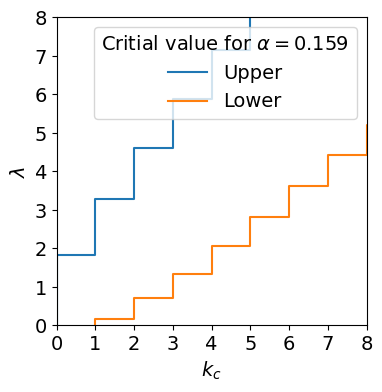

In [3]:
fig, ax = plt.subplots()

# need high resolution to find the right step
lambdas = np.linspace(0, 10, 300)
alpha = scipy.stats.norm.cdf(-1)
ax.step(
    scipy.stats.poisson.ppf(alpha, mu=lambdas), lambdas, label="Upper", where="post"
)
ax.step(
    scipy.stats.poisson.isf(alpha, mu=lambdas) + 1, lambdas, label="Lower", where="post"
)
ax.legend(title=rf"Critial value for $\alpha={alpha:.3f}$")

ax.set_ylabel(r"$\lambda$")
ax.set_xlabel("$k_c$")
ax.set_xticks(range(9))
ax.set_xlim(0, 8)
ax.set_yticks(range(9))
ax.set_ylim(0, 8)
fig.savefig("garwood.pdf", bbox_inches="tight")

In [4]:
def poisson_interval(n, alpha):
    """Using directly the PDG formulas"""
    if n == 0:
        alpha = 2 * alpha  # one-sided
        return 0.0, 0.5 * scipy.stats.chi2(df=2 * (n + 1)).isf(alpha)
    return (
        0.5 * scipy.stats.chi2(df=2 * n).ppf(alpha),
        0.5 * scipy.stats.chi2(df=2 * (n + 1)).isf(alpha),
    )


poisson_interval(0, 0.025)

(0.0, 2.9957322735539913)

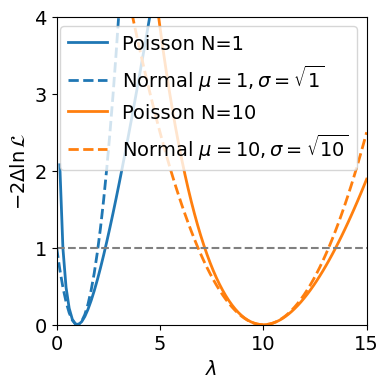

In [5]:
l = np.linspace(0, 15, 100)
fig, ax = plt.subplots()

for n, c in zip([1, 10], defaultcolors):
    ax.plot(
        l,
        -2 * scipy.stats.poisson.logpmf(n, l) + 2 * scipy.stats.poisson.logpmf(n, n),
        linewidth=2,
        color=c,
        label=f"Poisson N={n}",
    )
    ax.plot(
        l,
        (l - n) ** 2 / n,
        linewidth=2,
        color=c,
        linestyle="dashed",
        label=f"Normal $\mu={n},\sigma=\sqrt{{{n}}}$",
    )

ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$-2\Delta \ln\mathcal{L}$")
ax.set_ylim(0, 4)
ax.set_xlim(0, 15)
ax.axhline(1, color="grey", linestyle="dashed")
ax.legend()

## Poisson interval likelihood ratio construction

### $t_\mu$

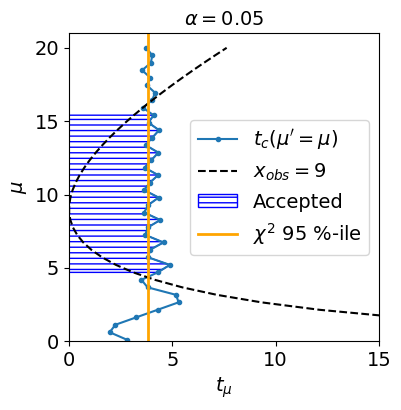

In [6]:
nobs = 9


def t_mu(mu, n):
    ll = scipy.stats.poisson.logpmf(n, mu)
    ll_hat = scipy.stats.poisson.logpmf(n, n)
    return -2 * (ll - ll_hat)


@np.vectorize
def t_mu_isf(mu, mu_prime, alpha):
    samples = scipy.stats.poisson.rvs(mu_prime, size=10_000)
    return np.quantile(t_mu(mu, samples), 1 - alpha, overwrite_input=True)


mus = np.linspace(0.1, 20, 40)
tc = t_mu_isf(mus, mus, 0.05)
tobs = t_mu(mus, nobs)

fig, ax = plt.subplots()
ax.plot(tc, mus, label=r"$t_{c}(\mu'=\mu)$", marker=".")
ax.plot(tobs, mus, label=f"$x_{{obs}}={nobs}$", color="k", linestyle="--")
ax.fill_betweenx(mus, 0, tc, where=tobs<tc, hatch="---", facecolor="none", edgecolor="blue", label="Accepted")

ax.axvline(
    scipy.stats.chi2.isf(0.05, df=1),
    linewidth=2,
    color="orange",
    label="$\chi^2$ 95 %-ile",
)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$t_{\mu}$")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.legend()
ax.set_title(r"$\alpha=0.05$")
fig.savefig("poisson_lr_asym.pdf", bbox_inches="tight")

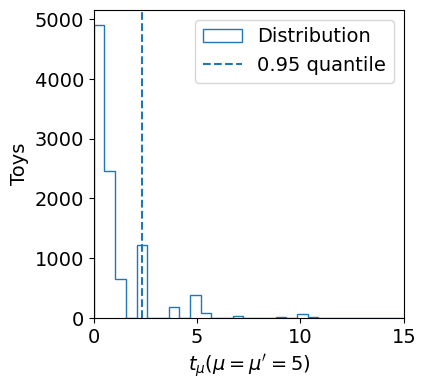

In [7]:
tdist = t_mu(5, scipy.stats.poisson.rvs(5, size=10_000))

fig, ax = plt.subplots()
ax.hist(tdist, histtype="step", bins=np.linspace(0, 15, 30), label="Distribution")
ax.axvline(np.quantile(tdist, 1 - alpha), linestyle="--", label="0.95 quantile")
ax.legend()
ax.set_ylabel("Toys")
ax.set_xlabel("$t_{\mu}(\mu=\mu'=5)$")
ax.set_xlim(0, 15)
fig.savefig("poisson_lr_tdist.pdf", bbox_inches="tight")

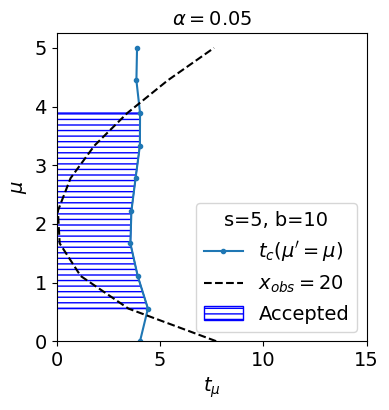

In [8]:
# add a background, show upward fluctuation of background gives unwanted lower limit (s=5, b=10, n=20)
# non-vectorized version

# Signal and background
s, b = 5, 10
nobs = 20

# Test statistic
def t_mu(mu, n):
    ll = scipy.stats.poisson.logpmf(n, mu * s + b)
    ll_hat = scipy.stats.poisson.logpmf(n, n)
    return -2 * (ll - ll_hat)

# Inverse survival function using MC sampling
def t_mu_isf(mu, mu_prime, alpha):
    samples = scipy.stats.poisson.rvs(mu_prime * s + b, size=10_000)
    t_vals = [t_mu(mu, n) for n in samples]
    return np.quantile(t_vals, 1 - alpha)

# Generate values of mu to scan
mus = np.linspace(0.001, 5, 10)

# Calculate tc and tobs manually for each mu
tc = []
tobs = []

for mu in mus:
    tc.append(t_mu_isf(mu, mu, 0.05))  # critical value
    tobs.append(t_mu(mu, nobs))        # observed test stat

# Plotting
fig, ax = plt.subplots()

ax.plot(tc, mus, label=r"$t_{c}(\mu'=\mu)$", marker=".")
ax.plot(tobs, mus, label=f"$x_{{obs}}={nobs}$", color="k", linestyle="--")

# Fill accepted region
ax.fill_betweenx(
    mus,
    0,
    tc,
    where=np.array(tobs) < np.array(tc),
    hatch="---",
    facecolor="none",
    edgecolor="blue",
    label="Accepted",
)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$t_{\mu}$")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}")
ax.set_title(r"$\alpha=0.05$")
fig.savefig("poissonsb_lr_nonvec.pdf", bbox_inches="tight")

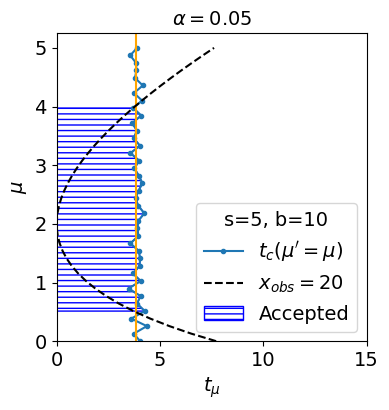

In [9]:
# add a background, show upward fluctuation of background gives unwanted lower limit (s=5, b=10, n=20)
s, b = 5, 10
nobs = 20


def t_mu(mu, n):
    ll = scipy.stats.poisson.logpmf(n, mu * s + b)
    ll_hat = scipy.stats.poisson.logpmf(n, n)
    return -2 * (ll - ll_hat)


@np.vectorize
def t_mu_isf(mu, mu_prime, alpha):
    samples = scipy.stats.poisson.rvs(mu_prime * s + b, size=10_000)
    return np.quantile(t_mu(mu, samples), 1 - alpha, overwrite_input=True)


mus = np.linspace(0.001, 5, 40)

fig, ax = plt.subplots()

tc = t_mu_isf(mus, mus, 0.05)
tobs = t_mu(mus, nobs)
ax.plot(tc, mus, label=r"$t_{c}(\mu'=\mu)$", marker=".")
ax.axvline(scipy.stats.chi2.ppf(0.95, df=1), color="orange")
ax.plot(tobs, mus, label=f"$x_{{obs}}={nobs}$", color="k", linestyle="--")
ax.fill_betweenx(
    mus,
    0,
    tc,
    where=tobs < tc,
    hatch="---",
    facecolor="none",
    edgecolor="blue",
    label="Accepted",
)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$t_{\mu}$")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}")
ax.set_title(r"$\alpha=0.05$")
fig.savefig("poissonsb_lr.pdf", bbox_inches="tight")

### $q_\mu$, $\tilde{q}_\mu$

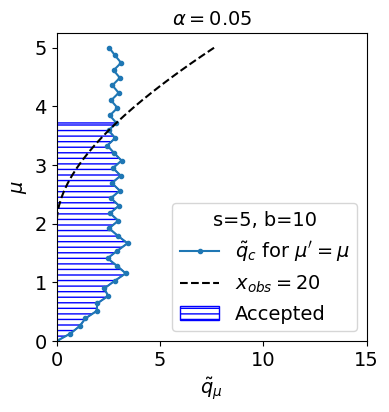

In [13]:
# use q_mu to prevent the issue (s=5, b=10, n=20)
s, b = 5, 10
nobs = 20

def q_mu(mu, n, tilde=True):
    # tilde: if mu_hat < 0, use ll(0)
    # if mu_hat > mu, use ll(mu)   
    mn = 0 if tilde else -np.inf
    mu_hat = np.clip((n - b) / s, mn, mu)
    ll = scipy.stats.poisson.logpmf(n, mu * s + b)
    ll_hat = scipy.stats.poisson.logpmf(n, mu_hat * s + b)
    t_mu = -2 * (ll - ll_hat)
    return t_mu

@np.vectorize
def q_mu_isf(mu, mu_prime, alpha):
    samples = scipy.stats.poisson.rvs(mu_prime * s + b, size=10_000)
    return np.quantile(q_mu(mu, samples), 1 - alpha, overwrite_input=True)

mus = np.linspace(0.001, 5, 40)
qc = q_mu_isf(mus, mus, 0.05)
qobs = q_mu(mus, nobs)

fig, ax = plt.subplots()
ax.plot(qc, mus, label=r"$\tilde{q}_{c}$ for $\mu'=\mu$", marker=".")
ax.plot(qobs, mus, label=f"$x_{{obs}}={nobs}$", color="k", linestyle="--")
ax.fill_betweenx(mus, 0, qc, where=qobs<=qc, hatch="---", facecolor="none", edgecolor="blue", label="Accepted")
#ax.axvline(
#    scipy.stats.chi2.isf(0.1, df=1), color="orange", label="half-$\chi^2$ 95 %-ile"
#)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$\tilde{q}_{\mu}$")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}")
ax.set_title(r"$\alpha=0.05$")
fig.savefig("poissonsb_qmu_asym.pdf", bbox_inches="tight")

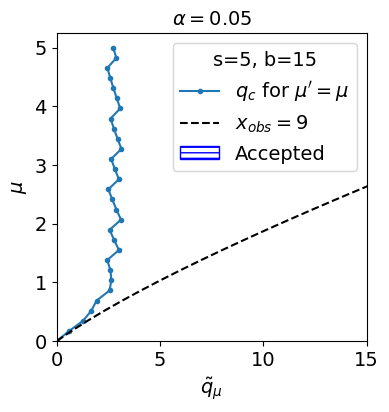

In [14]:
s, b = 5, 15
nobs = 9
# show effect of b undefluctuation (s=5, b=15, nobs=9)

def q_mu(mu, n, tilde=True):
    # tilde: if mu_hat < 0, use ll(0)
    # if mu_hat > mu, use ll(mu)   
    mn = 0 if tilde else -np.inf
    mu_hat = np.clip((n - b) / s, mn, mu)
    ll = scipy.stats.poisson.logpmf(n, mu * s + b)
    ll_hat = scipy.stats.poisson.logpmf(n, mu_hat * s + b)
    t_mu = -2 * (ll - ll_hat)
    return t_mu

@np.vectorize
def q_mu_isf(mu, mu_prime, alpha):
    samples = scipy.stats.poisson.rvs(mu_prime * s + b, size=10000)
    return np.quantile(q_mu(mu, samples), 1 - alpha, overwrite_input=True)

mus = np.linspace(0.001, 5, 30)

fig, ax = plt.subplots()

qc = q_mu_isf(mus, mus, 0.05)
qobs = q_mu(mus, nobs)
ax.plot(qc, mus, label=r"$q_{c}$ for $\mu'=\mu$", marker=".")
ax.plot(qobs, mus, label=f"$x_{{obs}}={nobs}$", color="k", linestyle="--")
ax.fill_betweenx(mus, 0, qc, where=qobs<=qc, hatch="---", facecolor="none", edgecolor="blue", label="Accepted")
#ax.axvline(scipy.stats.chi2.ppf(0.9, df=1))

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$\tilde{q}_{\mu}$")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}")
ax.set_title(r"$\alpha=0.05$")
fig.savefig("poissonsb_qmu_under.pdf", bbox_inches="tight")

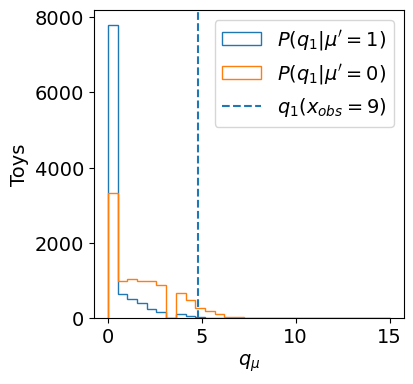

In [15]:
qdist = q_mu(1, scipy.stats.poisson.rvs(1 * s + b, size=10_000))
q0dist = q_mu(1, scipy.stats.poisson.rvs(0 * s + b, size=10_000))

fig, ax = plt.subplots()
ax.hist(qdist, histtype="step", bins=np.linspace(0, 15, 30), label="$P(q_1|\mu'=1)$")
ax.hist(q0dist, histtype="step", bins=np.linspace(0, 15, 30), label="$P(q_1|\mu'=0)$")
ax.axvline(q_mu(1, nobs), linestyle="--", label="$q_1(x_{obs}=9)$")

ax.legend()
ax.set_ylabel("Toys")
ax.set_xlabel(r"$q_{\mu}$")
fig.savefig("poissonsb_lr_qdist.pdf", bbox_inches="tight")

### $\mathrm{CL_s}$

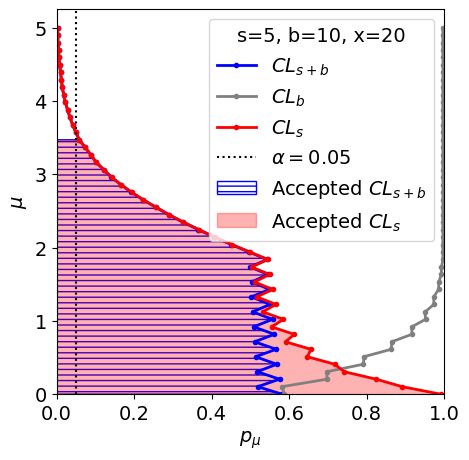

In [16]:
# use CLs to prevent too stringent limits
s, b = 5, 10
nobs = 20

def q_mu(mu, n, tilde=True):
    # tilde: if mu_hat < 0, use ll(0)
    # if mu_hat > mu, use ll(mu)   
    mn = 0 if tilde else -np.inf
    mu_hat = np.clip((n - b) / s, mn, mu)
    ll = scipy.stats.poisson.logpmf(n, mu * s + b)
    ll_hat = scipy.stats.poisson.logpmf(n, mu_hat * s + b)
    t_mu = -2 * (ll - ll_hat)
    return t_mu

@np.vectorize
def q_mu_sf(mu, mu_prime, q_mu_obs):
    samples = scipy.stats.poisson.rvs(mu_prime * s + b, size=100_000)
    return np.sum(q_mu(mu, samples) > q_mu_obs) / 100_000

mus = np.linspace(0.001, 5, 50)
q_mu_obs = q_mu(mus, nobs)
CLsb = q_mu_sf(mus, mus, q_mu_obs)
CLb = q_mu_sf(mus, 0, q_mu_obs)
CLs = CLsb / CLb

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(CLsb, mus, label="$CL_{s+b}$", linewidth=2, color="b", marker=".")
ax.plot(CLb, mus, label="$CL_b$", linewidth=2, color="grey", marker=".")
ax.plot(CLs, mus, label="$CL_s$", linewidth=2, color="r", marker=".")
ax.axvline(0.05, color="k", linestyle=":", label=r"$\alpha=0.05$")
ax.fill_betweenx(mus, 0, CLsb, where=CLsb > 0.05, hatch="---", facecolor="none", edgecolor="blue", label="Accepted $CL_{s+b}$")
ax.fill_betweenx(
    mus, 0, CLs, where=CLs >= 0.05, color="r", alpha=0.3, label="Accepted $CL_{s}$"
)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$p_{\mu}$")
ax.set_xlim(0, 1)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}, x={nobs}")
fig.savefig("poissonsb_pvals_cls.pdf", bbox_inches="tight")

In [17]:
def cls(mu, nobs):
    return q_mu_sf(mu, mu, q_mu(mu, nobs)) / q_mu_sf(mu, 0, q_mu(mu, nobs))

ultoys = scipy.optimize.root_scalar(lambda mu: cls(mu, nobs) - 0.05, bracket=(1e-3, 5))
print(ultoys)

      converged: True
           flag: converged
 function_calls: 36
     iterations: 35
           root: 3.5765902303764125
         method: brentq


In [18]:
%%writefile card.txt
imax 1
jmax 1
kmax 0
---------------
bin          bin1
observation     20
---------------
bin            bin1  bin1
process         sig   bkg
process           0     1
rate              5    10

Writing card.txt


In [19]:
# if on coffea casa
%env PATH=opt/conda/bin/:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tmp/HiggsAnalysis/CombinedLimit/build/bin
%env LD_LIBRARY_PATH=/opt/conda/lib/:/tmp/HiggsAnalysis/CombinedLimit/build/lib
%env PYTHONPATH=/tmp/HiggsAnalysis/CombinedLimit/build/lib/python

env: PATH=opt/conda/bin/:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tmp/HiggsAnalysis/CombinedLimit/build/bin
env: LD_LIBRARY_PATH=/opt/conda/lib/:/tmp/HiggsAnalysis/CombinedLimit/build/lib
env: PYTHONPATH=/tmp/HiggsAnalysis/CombinedLimit/build/lib/python


In [23]:
!ulimit -s unlimited

In [24]:
%%bash
combine -M HybridNew --LHCmode LHC-limits card.txt --saveHybridResult

 <<< Combine >>> 
 <<< v10.0.0 >>>
>>> Random number generator seed is 123456
>>> using the Profile Likelihood test statistic modified for upper limits (Q_LHC)
>>> Method used is HybridNew



 *** Break *** segmentation violation
 Generating stack trace...
 0x00007fc0e1cbacae in RooNLLVar::RooNLLVar(char const*, char const*, RooAbsPdf&, RooAbsData&, RooArgSet const&, bool, RooAbsTestStatistic::Configuration const&) + 0x3e from /opt/conda/lib/libRooFitCore.so.6.26
 0x00007fc0e1b51e52 in RooAbsPdf::createNLL(RooAbsData&, RooLinkedList const&) + 0x1452 from /opt/conda/lib/libRooFitCore.so.6.26
 0x00007fc0e1b5a868 in RooAbsPdf::createNLL(RooAbsData&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&, RooCmdArg const&) + 0x118 from /opt/conda/lib/libRooFitCore.so.6.26
 0x00007fc0e4586fe8 in ProfiledLikelihoodTestStatOpt::createNLL(RooAbsPdf&, RooAbsData&) at /opt/conda/x86_64-conda-linux-gnu/include/c++/10.4.0/bits/unique_ptr.h:179 from /tmp/HiggsAnalysis/CombinedLimit/build/lib/libHiggsAnalysisCombinedLimit.so
 0x00007fc0e4587308 in ProfiledLikelihoodTestStatOpt::Evaluate(RooAbsData&, RooArgSet&) at /op

CalledProcessError: Command 'b'combine -M HybridNew --LHCmode LHC-limits card.txt --saveHybridResult\n'' returned non-zero exit status 139.

## Asymptotic approximation

$-\ln L$ tends towards normal distribution

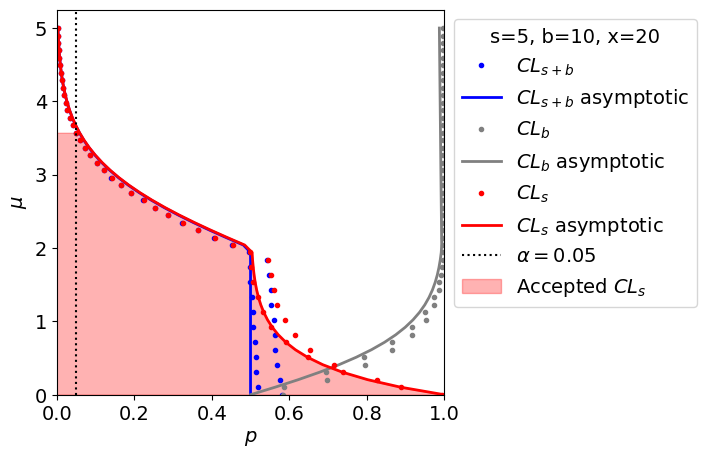

In [15]:
# implement formulae from CCGV
s, b = 5, 10
nobs = 20


def poisson_logpmf(n, l):
    # continuous version needed for asimov
    return scipy.special.xlogy(n, l) - l - scipy.special.loggamma(n + 1)


def q_mu(mu, n):
    # actually q_mu tilde
    # if mu_hat < 0, use ll(0)
    # if mu_hat > mu, use ll(mu)
    mu_hat = np.clip((n - b) / s, 0, mu)
    ll = poisson_logpmf(n, mu * s + b)
    ll_hat = poisson_logpmf(n, mu_hat * s + b)
    t_mu = -2 * (ll - ll_hat)
    return t_mu


@np.vectorize
def q_mu_sf_asym(mu, mu_prime, q_mu_obs):
    nc = np.sqrt(q_mu(mu, 0 * s + b))
    # = (mu - mu_prime) / sigma = q_A if mu'=0
    # Eqn. 65 (tilde quantities)
    return np.where(
        q_mu_obs <= nc * nc,
        scipy.stats.norm.sf(np.sqrt(q_mu_obs) - nc * (1 - mu_prime / mu)),
        scipy.stats.norm.sf((q_mu_obs - nc * nc * (1 - 2 * mu_prime / mu)) / (2 * nc)),
    )


q_mu_obs = q_mu(mus, nobs)
CLsb = q_mu_sf(mus, mus, q_mu_obs)
CLb = q_mu_sf(mus, 0, q_mu_obs)
CLs = CLsb / CLb
CLsb_asym = q_mu_sf_asym(mus, mus, q_mu_obs)
CLb_asym = q_mu_sf_asym(mus, 0, q_mu_obs)
CLs_asym = CLsb_asym / CLb_asym


fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(CLsb, mus, label="$CL_{s+b}$", linestyle="none", color="b", marker=".")
ax.plot(CLsb_asym, mus, label="$CL_{s+b}$ asymptotic", linewidth=2, color="b")

ax.plot(CLb, mus, label="$CL_{b}$", linestyle="none", color="grey", marker=".")
ax.plot(CLb_asym, mus, label="$CL_{b}$ asymptotic", linewidth=2, color="grey")

ax.plot(CLs, mus, label="$CL_{s}$", linestyle="none", color="r", marker=".")
ax.plot(CLs_asym, mus, label="$CL_{s}$ asymptotic", linewidth=2, color="r")

ax.axvline(0.05, color="k", linestyle=":", label=r"$\alpha=0.05$")

ax.fill_betweenx(
    mus,
    0,
    CLs_asym,
    where=CLs_asym > 0.05,
    color="r",
    alpha=0.3,
    label="Accepted $CL_{s}$",
)

ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r"$p$")
ax.set_xlim(0, 1)
ax.set_ylim(0, None)
ax.legend(title=f"{s=}, {b=}, x={nobs}", bbox_to_anchor=(1, 1))
fig.savefig("poissonsb_pvals_cls_asym.pdf", bbox_inches="tight")

In [16]:
def cls_asym(mu, nobs):
    return q_mu_sf_asym(mu, mu, q_mu(mu, nobs)) / q_mu_sf_asym(mu, 0, q_mu(mu, nobs))


ul = scipy.optimize.root_scalar(lambda mu: cls_asym(mu, nobs) - 0.05, bracket=(1e-3, 5))
print(ul)

      converged: True
           flag: converged
 function_calls: 13
     iterations: 12
           root: 3.662303622948181
         method: brentq


In [17]:
ulexp = scipy.optimize.root_scalar(lambda mu: cls_asym(mu, b) - 0.05, bracket=(1e-3, 5))
print(ulexp)

      converged: True
           flag: converged
 function_calls: 12
     iterations: 11
           root: 1.5078689584596476
         method: brentq


In [ ]:
%%writefile card.txt
imax 1
jmax 1
kmax 0
---------------
bin          bin1
observation    20
---------------
bin            bin1  bin1
process         sig   bkg
process           0     1
rate              5    10

Overwriting card.txt


In [ ]:
%%bash
combine -M AsymptoticLimits card.txt


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

 <<< Combine >>> 
>>> random number generator seed is 123456
>>> method used is AsymptoticLimits

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt


 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 3.6595
Expected  2.5%: r < 0.7480
Expected 16.0%: r < 1.0329
Expected 50.0%: r < 1.5078
Expected 84.0%: r < 2.2471
Expected 97.5%: r < 3.2243

Done in 0.00 min (cpu), 0.00 min (real)


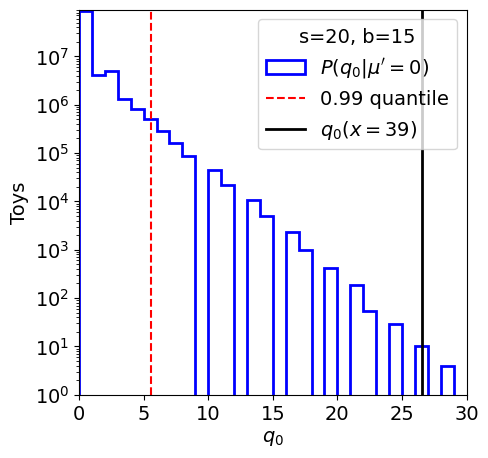

In [21]:
# discovery example
s, b = 20, 15
nobs = 39


def poisson_logpmf(n, l):
    # continuous version needed for asimov
    return scipy.special.xlogy(n, l) - l - scipy.special.loggamma(n + 1)


def q_0(n):
    mu_hat = np.maximum(0, (n - b) / s)
    ll = poisson_logpmf(n, 0 * s + b)
    ll_hat = poisson_logpmf(n, mu_hat * s + b)
    t_mu = -2 * (ll - ll_hat)
    return t_mu


q_0_obs = q_0(nobs)
nsamp = int(1e8)
q_0_dist = q_0(scipy.stats.poisson.rvs(0 * s + b, size=nsamp))

fig, ax = plt.subplots(figsize=(5, 5))

ax.hist(
    q_0_dist,
    bins=np.linspace(0, 30, 31),
    histtype="step",
    color="b",
    linewidth=2,
    label="$P(q_0|\mu'=0)$",
)
qvals = np.linspace(0, 30, 50)
#ax.plot(
#    qvals,
#    scipy.stats.chi2.pdf(qvals, df=1) * nsamp * 0.5,
#    label="half-$\chi^2$ pdf",
#    color="b",
#    linestyle="--",
#)
ax.axvline(np.quantile(q_0_dist, 1 - 0.01), linestyle="--", color="r", label="0.99 quantile")
ax.axvline(q_0_obs, color="k", linewidth=2, label=f"$q_0(x={nobs})$")

ax.set_ylabel("Toys")
ax.set_xlabel(r"$q_0$")
ax.set_xlim(0, 30)
ax.set_ylim(1, None)
ax.set_yscale("log")
ax.legend(title=f"{s=}, {b=}")
fig.savefig("poissonsb_q0_dist.pdf", bbox_inches="tight")

# Uncertainty schemes

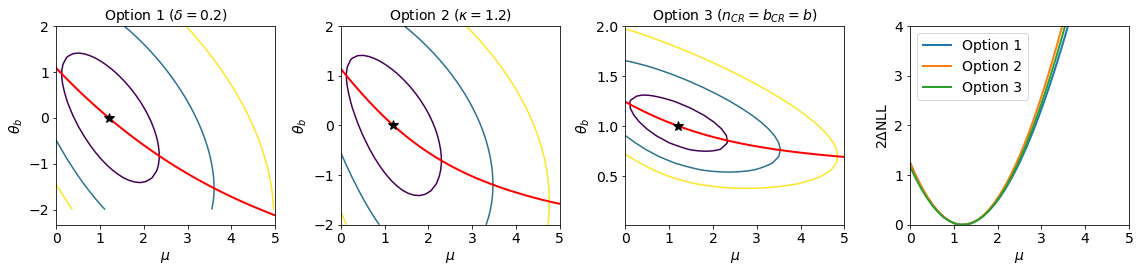

In [ ]:
s, b = 10, 25
nobs = 37


def opt1_nll(mu, theta):
    delta = 0.2
    return (
        -scipy.stats.poisson.logpmf(nobs, mu * s + b * (1 + delta * theta))
        + theta**2 / 2
    )


def opt2_nll(mu, theta):
    kappa = 1.2
    return -scipy.stats.poisson.logpmf(nobs, mu * s + b * kappa**theta) + theta**2 / 2


def opt3_nll(mu, theta):
    nCR = b
    bCR = b
    return -scipy.stats.poisson.logpmf(
        nobs, mu * s + b * theta
    ) - scipy.stats.poisson.logpmf(nCR, bCR * theta)


models = [opt1_nll, opt2_nll, opt3_nll]
bestfits = [scipy.optimize.minimize(lambda p: model(*p), [1, 0.1]) for model in models]


def profile(model):
    @np.vectorize
    def mintheta(mu):
        return scipy.optimize.minimize(lambda p: model(mu, p), [0.1]).x

    return mintheta


mus1d = np.linspace(0, 5, 40)
mus, thetas = np.meshgrid(mus1d, np.linspace(-2, 2, 30), indexing="ij")


fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].contour(mus, thetas, models[0](mus, thetas) - bestfits[0].fun, levels=[1, 4, 9])
axes[0].plot(mus1d, profile(models[0])(mus1d), color="r", linewidth=2)
axes[0].plot(*bestfits[0].x, marker="*", color="k", markersize=10)

axes[1].contour(mus, thetas, models[1](mus, thetas) - bestfits[1].fun, levels=[1, 4, 9])
axes[1].plot(mus1d, profile(models[1])(mus1d), color="r", linewidth=2)
axes[1].plot(*bestfits[1].x, marker="*", color="k", markersize=10)

mus, thetas = np.meshgrid(mus1d, np.linspace(0.01, 2, 30), indexing="ij")
axes[2].contour(mus, thetas, models[2](mus, thetas) - bestfits[2].fun, levels=[1, 4, 9])
axes[2].plot(mus1d, profile(models[2])(mus1d), color="r", linewidth=2)
axes[2].plot(*bestfits[2].x, marker="*", color="k", markersize=10)

for i, ax in enumerate(axes[:3]):
    ax.set_xlabel("$\mu$")
    ax.set_ylabel(r"$\theta_b$")

axes[0].set_title("Option 1 ($\delta=0.2$)")
axes[1].set_title("Option 2 ($\kappa=1.2$)")
axes[2].set_title("Option 3 ($n_{CR}=b_{CR}=b$)")


def profilev(model):
    @np.vectorize
    def nll(mu):
        return scipy.optimize.minimize(lambda p: model(mu, p), [0.1]).fun

    return nll


axes[3].set_xlabel("$\mu$")
axes[3].set_ylabel("2$\Delta$NLL")
axes[3].plot(
    mus1d, profilev(models[0])(mus1d) - bestfits[0].fun, linewidth=2, label="Option 1"
)
axes[3].plot(
    mus1d, profilev(models[1])(mus1d) - bestfits[1].fun, linewidth=2, label="Option 2"
)
axes[3].plot(
    mus1d, profilev(models[2])(mus1d) - bestfits[2].fun, linewidth=2, label="Option 3"
)
axes[3].set_xlim(0, 5)
axes[3].set_ylim(0, 4)
axes[3].legend()

fig.tight_layout()
fig.savefig("profiles.pdf", bbox_inches="tight")